# Hard Voting Classification

This notebook performs classification using a Hard Voting ensemble on Galaxy10 embeddings extracted via a ResNet-101 model pretrained on ImageNet.

We include:
- Evaluation of a large ensemble using hard majority voting
- Accuracy, balanced accuracy, precision, recall, and F1 score
- Confusion matrix and per-class report
- Hierarchical class relation analysis

In hard voting, each model predicts independently, and the final prediction is the class most models agree on.
We use a diverse set of classifiers including KNN, SVM, Decision Tree, Random Forest, AdaBoost, Logistic Regression, Gradient Boosting, Extra Trees, Naive Bayes, MLP, and more.
Because of the large number of models involved, we use standard hyperparameters to ensure balanced training time and consistency across classifiers.


## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    BaggingClassifier,
    VotingClassifier
)
from sklearn.linear_model import (
    LogisticRegression,
    RidgeClassifier,
    Perceptron,
    PassiveAggressiveClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

## PCA on ResNet101 Embeddings

Applies PCA to reduce the dimensionality of the entire dataset using the precomputed ResNet101 embeddings.


In [2]:
# Load data
data = np.load('Galaxy10_Embedding_vectors/galaxy10_resnet101_embeddings_augmented_balanced.npz', allow_pickle=True)

# Separate train, val, and test
X_train = data['train_features']
y_train = data['train_labels']
X_val = data['val_features']
y_val = data['val_labels']
X_test = data['test_features']
y_test = data['test_labels']
class_names = data['class_names']

print(f"Original Train size: {X_train.shape[0]}")
print(f"Original Validation size: {X_val.shape[0]}")
print(f"Original Test size: {X_test.shape[0]}")
print(f"Original Embedding dimension: {X_train.shape[1]}")

# PCA to keep 95% variance (fit only on training data)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print(f"Reduced Train dimension: {X_train_pca.shape[1]}")
print(f"Reduced Validation dimension: {X_val_pca.shape[1]}")
print(f"Reduced Test dimension: {X_test_pca.shape[1]}")


Original Train size: 48970
Original Validation size: 3269
Original Test size: 3268
Original Embedding dimension: 2048
Reduced Train dimension: 25
Reduced Validation dimension: 25
Reduced Test dimension: 25


## Hard Voting Ensemble with Diverse Classifiers

This block builds and evaluates a hard voting ensemble that combines predictions from a diverse set of classifiers. Each model contributes one vote toward the final prediction, and the majority vote determines the output.

- **K-Nearest Neighbors** (`KNeighborsClassifier`): classifies based on the majority of nearest neighbors.
- **Support Vector Machine** (`SVC`): finds the optimal hyperplane separating classes using RBF kernel.
- **Decision Tree** (`DecisionTreeClassifier`): tree-based splits based on feature thresholds.
- **Random Forest** (`RandomForestClassifier`): ensemble of decision trees trained on random subsets.
- **AdaBoost** (`AdaBoostClassifier`): boosts weak learners with reweighted training samples.
- **Logistic Regression** (`LogisticRegression`): linear model estimating class probabilities with a logistic function.
- **Gaussian Naive Bayes** (`GaussianNB`): assumes feature independence and Gaussian-distributed features.
- **Gradient Boosting** (`GradientBoostingClassifier`): sequential tree boosting minimizing errors.
- **Extra Trees** (`ExtraTreesClassifier`): randomized tree ensemble with faster training than RF.
- **Quadratic Discriminant Analysis** (`QDA`): models class conditional distributions with full covariances.
- **Ridge Classifier** (`RidgeClassifier`): linear classifier with L2 regularization.
- **Passive-Aggressive** (`PassiveAggressiveClassifier`): efficient online learning for large datasets.
- **Perceptron** (`Perceptron`): basic linear binary classifier with SGD updates.
- **Bagging** (`BaggingClassifier`): bootstrapped ensemble of estimators (default is trees).
- **Multilayer Perceptron** (`MLPClassifier`): shallow fully connected neural network with one hidden layer.


In [ ]:
# Define all base models
classifiers = [
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale')),
    ('dt', DecisionTreeClassifier(max_depth=None, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('ada', AdaBoostClassifier(n_estimators=100, learning_rate=1.0, algorithm='SAMME', random_state=42)),
    ('logreg', LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)),
    ('gnb', GaussianNB()),
    ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)),
    ('et', ExtraTreesClassifier(n_estimators=100, random_state=42)),
    ('qda', QuadraticDiscriminantAnalysis()),
    ('ridge', RidgeClassifier()),
    ('pa', PassiveAggressiveClassifier(max_iter=1000, random_state=42)),
    ('perceptron', Perceptron(max_iter=1000, random_state=42)),
    ('bagging', BaggingClassifier(random_state=42)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42))
]

# Create hard voting ensemble
voting_clf = VotingClassifier(estimators=classifiers, voting='hard')
voting_clf.fit(X_train, y_train)

# Predict on test set
y_pred = voting_clf.predict(X_test)

# Evaluate on test set
acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

# Print results
print(f"Accuracy:            {acc:.4f}")
print(f"Balanced Accuracy:   {bal_acc:.4f}")
print(f"Macro Precision:     {precision:.4f}")
print(f"Macro Recall:        {recall:.4f}")
print(f"Macro F1 Score:      {f1:.4f}")


## Confusion Matrices

Displays two confusion matrices: one with raw counts and one with row-wise percentages for the test set predictions.


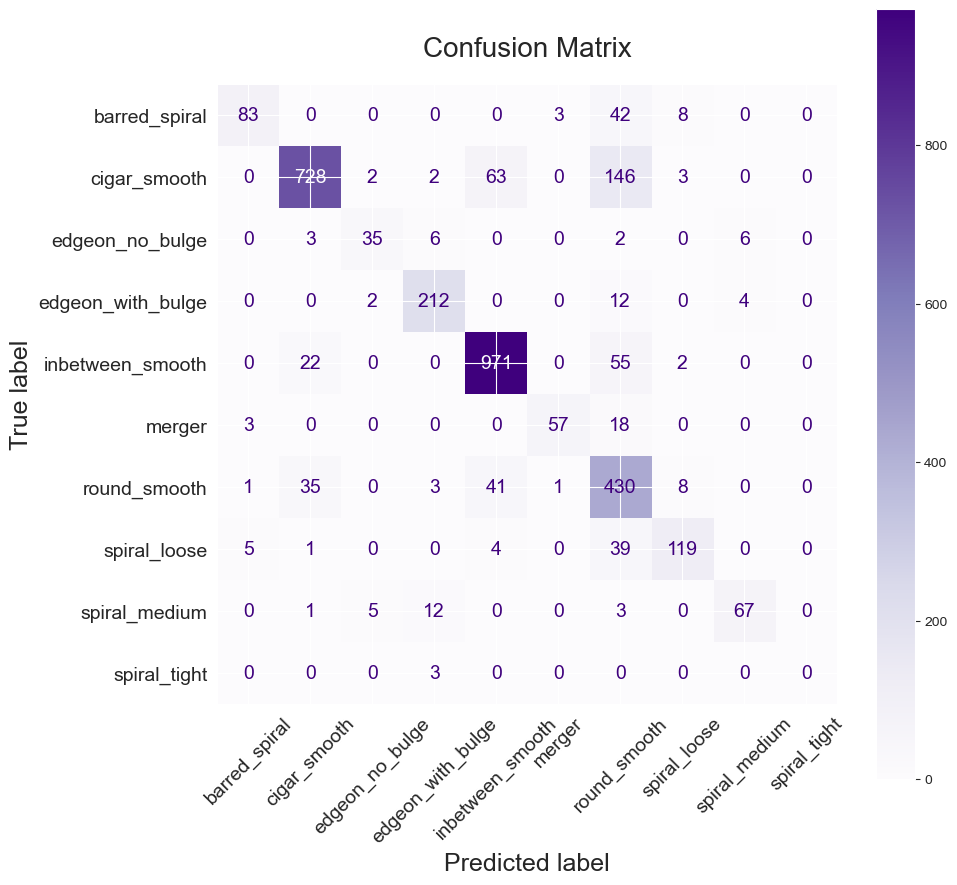

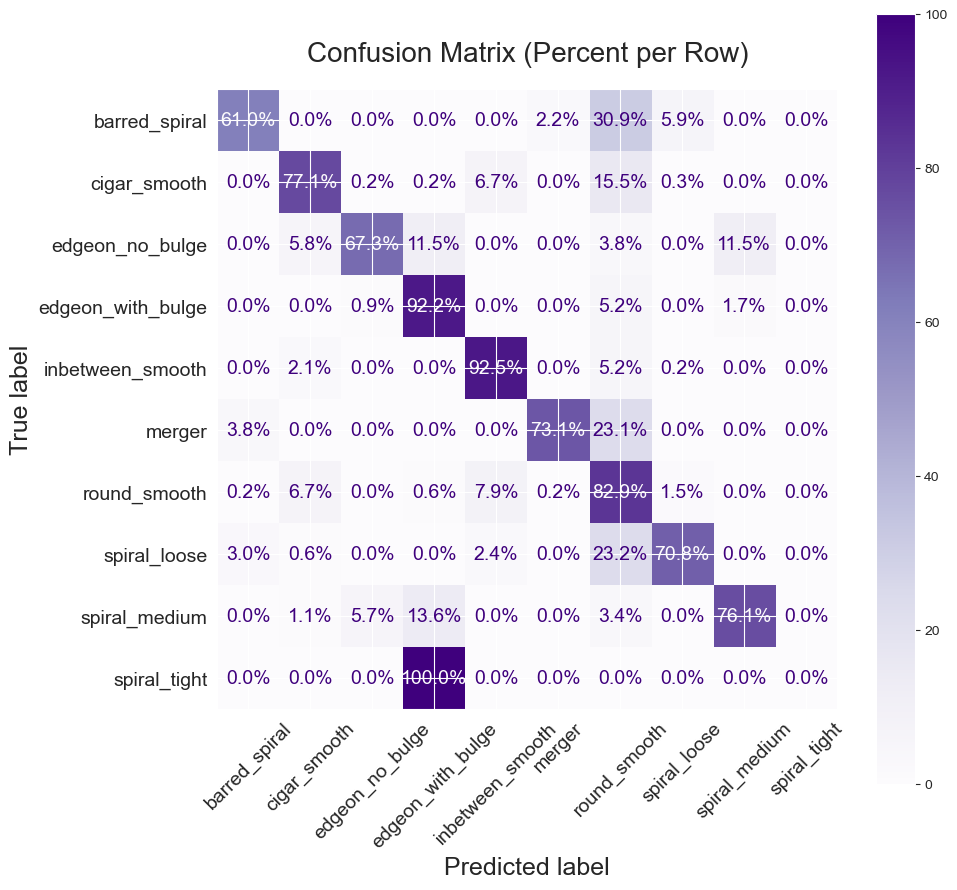

In [8]:
# Confusion matrix (raw counts)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Purples', xticks_rotation=45)

ax.set_title("Confusion Matrix", fontsize=20, pad=20)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
ax.tick_params(axis='both', labelsize=14)
for text in disp.text_.ravel():
    text.set_fontsize(14)

plt.show()

# Confusion matrix (row-wise percentages)
cm_percent = cm.astype(float) / cm.sum(axis=1)[:, None] * 100
disp_percent = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp_percent.plot(ax=ax, cmap='Purples', xticks_rotation=45, values_format='.1f')

for text in disp_percent.text_.ravel():
    text.set_text(f"{float(text.get_text()):.1f}%")
    text.set_fontsize(14)

ax.set_title("Confusion Matrix (Percent per Row)", fontsize=20, pad=20)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
ax.tick_params(axis='both', labelsize=14)

plt.show()

## Classification Report

Prints precision, recall, F1 score, and support for each class in the test set.


In [9]:
print(classification_report(y_test, y_pred, target_names=class_names, digits=4, zero_division=0))

                   precision    recall  f1-score   support

    barred_spiral     0.9022    0.6103    0.7281       136
     cigar_smooth     0.9215    0.7712    0.8397       944
  edgeon_no_bulge     0.7955    0.6731    0.7292        52
edgeon_with_bulge     0.8908    0.9217    0.9060       230
 inbetween_smooth     0.8999    0.9248    0.9122      1050
           merger     0.9344    0.7308    0.8201        78
     round_smooth     0.5756    0.8285    0.6793       519
     spiral_loose     0.8500    0.7083    0.7727       168
    spiral_medium     0.8701    0.7614    0.8121        88
     spiral_tight     0.0000    0.0000    0.0000         3

         accuracy                         0.8268      3268
        macro avg     0.7640    0.6930    0.7199      3268
     weighted avg     0.8491    0.8268    0.8303      3268



## Hierarchical Clustering of Predicted Classes

We analyzed how the model groups Galaxy10 classes by performing hierarchical clustering based on the **mean embedding** (centroid) of each **predicted class** in the test set.

For each class that was actually predicted by the model, we computed its centroid by averaging the embeddings of all test samples assigned to that class. This approach reflects how the model internally organizes its predictions in feature space.

We used **Ward’s method** on the pairwise **Euclidean distances** between class centroids:

$$
\text{Distance}(C_i, C_j) = \left\| \mu_i - \mu_j \right\|_2
$$

This method reveals how semantically close the predicted classes are according to the model’s learned representation.

> Note: Classes not predicted at all are excluded from the dendrogram.

Skipping class spiral_tight: no predictions in test set.


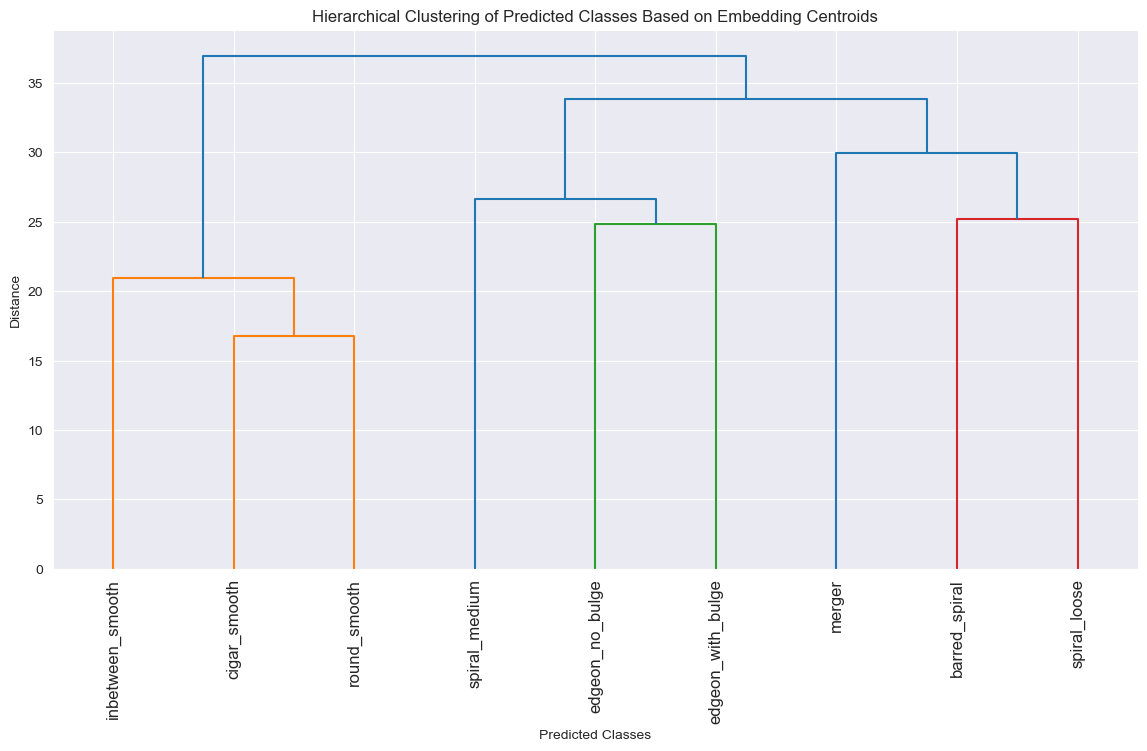

In [10]:
# Make sure class names are a numpy array
class_names = np.array(class_names)

# Find the unique classes predicted by the model
predicted_classes = np.unique(y_pred)

centroids_pred = []
valid_class_names_pred = []

for cls in range(len(class_names)):
    idx = np.where(y_pred == cls)[0]

    if len(idx) == 0:
        print(f"Skipping class {class_names[cls]}: no predictions in test set.")
        continue
    else:
        centroid = np.mean(X_test[idx], axis=0)
        centroids_pred.append(centroid)
        valid_class_names_pred.append(class_names[cls])

centroids_pred = np.array(centroids_pred)
valid_class_names_pred = np.array(valid_class_names_pred)

# Perform hierarchical clustering
linked_pred = linkage(centroids_pred, method='ward')

# Plot dendrogram
plt.figure(figsize=(14, 7))
dendrogram(linked_pred, labels=valid_class_names_pred, leaf_rotation=90)
plt.title('Hierarchical Clustering of Predicted Classes Based on Embedding Centroids')
plt.xlabel('Predicted Classes')
plt.ylabel('Distance')
plt.show()